In [1]:
import plotly.express as px
from collections import Counter
import pandas as pd
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import seaborn as sns

# `data/`- Add directory to Python search path
data_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
sys.path.append(data_path)

import data_loader

Used data path: C:\ZHAW_local\semester_6_local\DS in Health\project_work\data


# Data import

In [ ]:
train_dataset = data_loader.train_dataset
val_dataset = data_loader.val_dataset
test_dataset = data_loader.test_dataset

train_dataset_raw = data_loader.train_dataset_raw
val_dataset_raw = data_loader.val_dataset_raw
test_dataset_raw = data_loader.test_dataset_raw

In [7]:
def count_class_samples(dataset, dataset_name="Dataset"):
    """
    Counts the number of images per class in a dataset and returns the results.
    """
    labels = [label for _, label in dataset.samples]  # List of all labels
    counts = Counter(labels)  # Count occurrences per class
    class_counts_named = {dataset.classes[idx]: count for idx, count in counts.items()}
    
    print(f"\n📊 Number of images per class in {dataset_name}:")
    for class_name, count in class_counts_named.items():
        print(f"  {class_name}: {count}")

    return class_counts_named

# Compute and display results for training, validation, and test sets
train_counts_named = count_class_samples(train_dataset_raw, "Training set")
val_counts_named = count_class_samples(val_dataset_raw, "Validation set")
test_counts_named = count_class_samples(test_dataset_raw, "Test set")


📊 Number of images per class in Training set:
  Parasitized: 11024
  Uninfected: 11024

📊 Number of images per class in Validation set:
  Parasitized: 1378
  Uninfected: 1377

📊 Number of images per class in Test set:
  Parasitized: 1377
  Uninfected: 1378


In [11]:
def get_data_path(filepath=None):
    if filepath is None:
        filepath = "../data_path.txt"  
    try:
        with open(filepath, "r") as f:
            return f.readline().strip()
    except FileNotFoundError:
        raise FileNotFoundError(f"Die Datei '{filepath}' wurde nicht gefunden! Stelle sicher, dass sie existiert.")

data_dir = get_data_path()

# Alle Dateitypen sammeln
file_types = []

for root, _, files in os.walk(data_dir):
    for file in files:
        ext = os.path.splitext(file)[1].lower()  # Dateiendung extrahieren
        file_types.append(ext)

# Zähle die Vorkommen der Dateitypen
file_counts = Counter(file_types)

# Ergebnisse ausgeben
print("Dateitypen im Dataset:")
for file_type, count in file_counts.items():
    print(f"{file_type}: {count} Dateien")

Dateitypen im Dataset:
.png: 27558 Dateien
.db: 2 Dateien


# Images analyis

Are all images RGB (3 channels)? True
Mean size: (132, 132)
Median size: (130, 130)


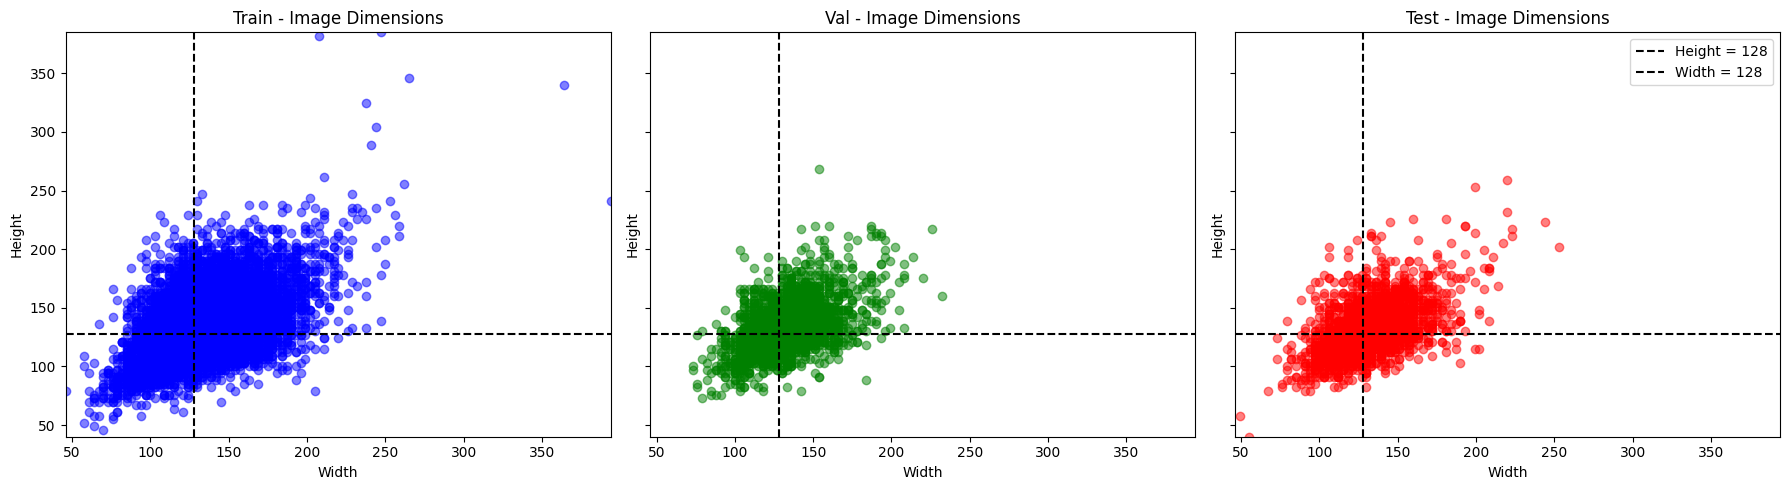

In [12]:
def get_image_dimensions(dataset, dataset_name):
    """
    Extracts image dimensions (Width, Height, Channels) for all images in a dataset.
    """
    data = []
    
    for img_path, _ in dataset.samples:
        with Image.open(img_path) as img:
            shape = img.size[::-1]  # (Height, Width)
            channels = len(img.getbands())  # Number of channels
            data.append({"Dataset": dataset_name, "Width": shape[1], "Height": shape[0], "Channels": channels})
    
    return pd.DataFrame(data)

# Create DataFrame with image dimensions
df_train = get_image_dimensions(train_dataset_raw, "train")
df_val = get_image_dimensions(val_dataset_raw, "val")
df_test = get_image_dimensions(test_dataset_raw, "test")

# Combine datasets into one DataFrame
df_images = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Check if all images have 3 channels
all_rgb = df_images["Channels"].nunique() == 1 and df_images["Channels"].iloc[0] == 3
print(f"Are all images RGB (3 channels)? {all_rgb}")

# Calculate statistics
mean_width, mean_height = int(df_images["Width"].mean()), int(df_images["Height"].mean())
median_width, median_height = int(df_images["Width"].median()), int(df_images["Height"].median())

print(f"Mean size: ({mean_width}, {mean_height})")
print(f"Median size: ({median_width}, {median_height})")

# Set axis limits
width_min, width_max = df_images["Width"].min(), df_images["Width"].max()
height_min, height_max = df_images["Height"].min(), df_images["Height"].max()

# Create scatter plots (Train, Val, Test)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)

# Colors for differentiation
colors = {"train": "blue", "val": "green", "test": "red"}

for i, dataset_name in enumerate(["train", "val", "test"]):
    subset = df_images[df_images["Dataset"] == dataset_name]
    
    if not subset.empty:
        axes[i].scatter(subset["Width"], subset["Height"], alpha=0.5, color=colors[dataset_name])
        axes[i].set_title(f"{dataset_name.capitalize()} - Image Dimensions")
        axes[i].set_xlabel("Width")
        axes[i].set_ylabel("Height")
        
        # Ensure same scale
        axes[i].set_xlim(width_min, width_max)
        axes[i].set_ylim(height_min, height_max)
        
        # Add reference lines at 128x128
        axes[i].axhline(y=128, color='black', linestyle='--', label="Height = 128")
        axes[i].axvline(x=128, color='black', linestyle='--', label="Width = 128")

# Add legend to the last plot
axes[-1].legend()

plt.tight_layout()
plt.show()

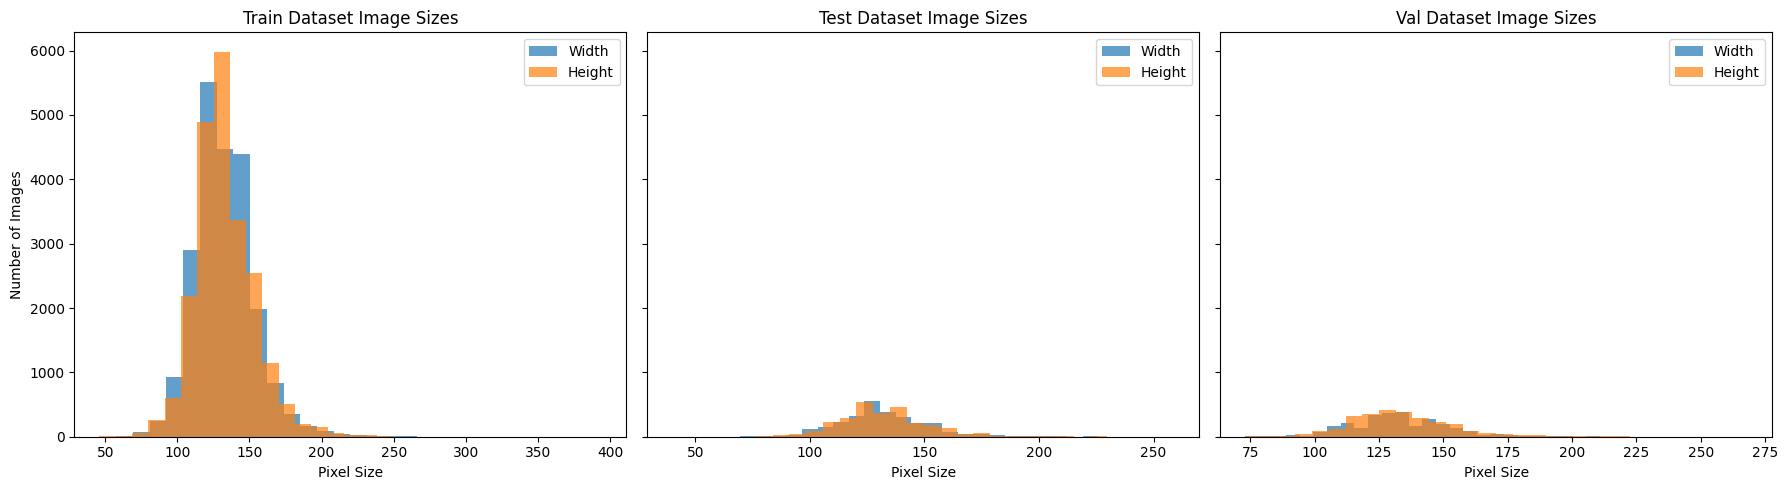

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Dataset names
dataset_names = ["train", "test", "val"]

for i, dataset in enumerate(dataset_names):
    subset = df_images[df_images["Dataset"] == dataset]

    if not subset.empty:
        axes[i].hist(subset["Width"].dropna(), bins=30, alpha=0.7, label="Width")
        axes[i].hist(subset["Height"].dropna(), bins=30, alpha=0.7, label="Height")
        axes[i].set_xlabel("Pixel Size")
        axes[i].set_title(f"{dataset.capitalize()} Dataset Image Sizes")
        axes[i].legend()

axes[0].set_ylabel("Number of Images")
plt.tight_layout()
plt.show()

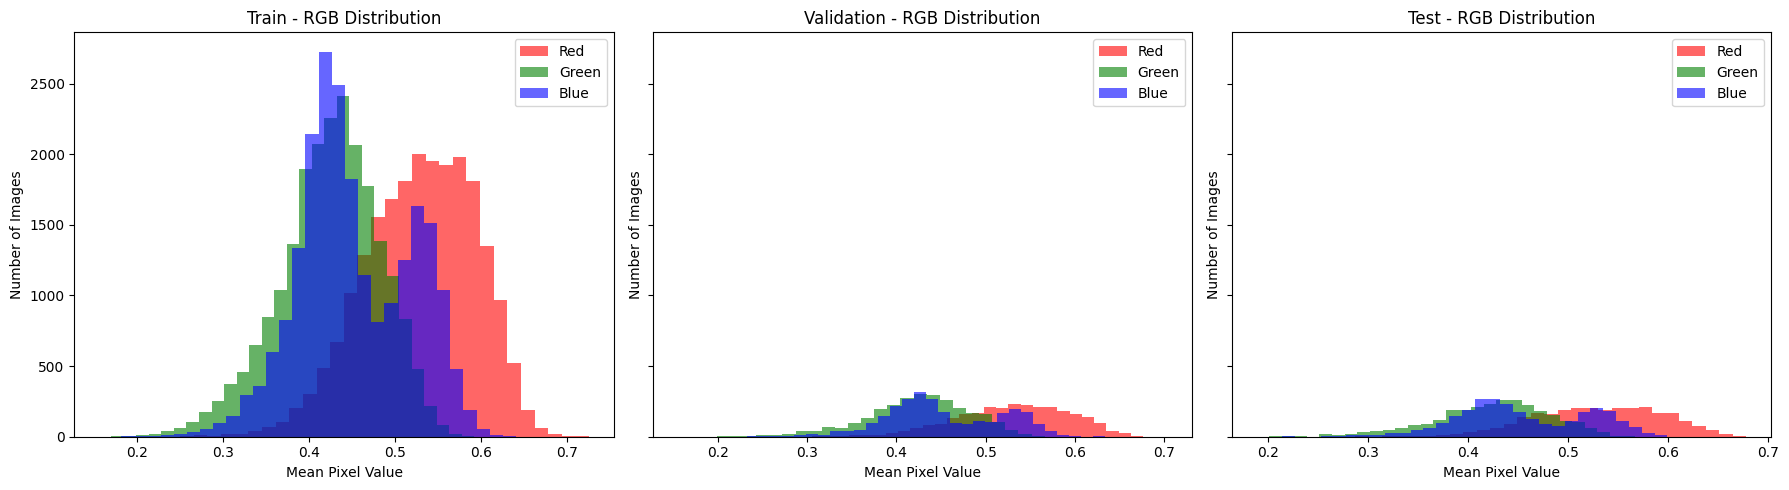

In [16]:
def compute_rgb_distribution(dataset, dataset_name):
    """
    Computes the mean RGB channel distributions for all images in a dataset.
    """
    r_values, g_values, b_values = [], [], []

    for img_path, _ in dataset.samples:
        with Image.open(img_path) as img:
            img = img.convert("RGB")  # Ensure RGB format
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            # Compute mean per channel
            r_values.append(img_array[:, :, 0].mean())
            g_values.append(img_array[:, :, 1].mean())
            b_values.append(img_array[:, :, 2].mean())

    return {
        "Dataset": dataset_name,
        "R": r_values,
        "G": g_values,
        "B": b_values,
    }

# Compute distributions for train, val, and test sets
train_rgb = compute_rgb_distribution(train_dataset_raw, "Train")
val_rgb = compute_rgb_distribution(val_dataset_raw, "Validation")
test_rgb = compute_rgb_distribution(test_dataset_raw, "Test")

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (rgb_data, dataset_name) in enumerate([(train_rgb, "Train"), (val_rgb, "Validation"), (test_rgb, "Test")]):
    axes[i].hist(rgb_data["R"], bins=30, alpha=0.6, color="red", label="Red")
    axes[i].hist(rgb_data["G"], bins=30, alpha=0.6, color="green", label="Green")
    axes[i].hist(rgb_data["B"], bins=30, alpha=0.6, color="blue", label="Blue")

    axes[i].set_title(f"{dataset_name} - RGB Distribution")
    axes[i].set_xlabel("Mean Pixel Value")
    axes[i].set_ylabel("Number of Images")
    axes[i].legend()

plt.tight_layout()
plt.show()

# Data distribution

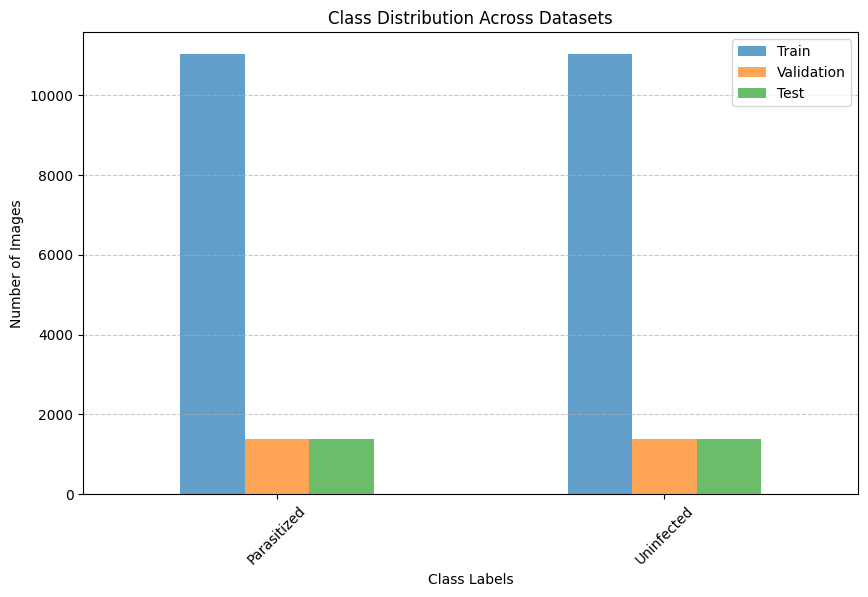

In [15]:
# Function to count class distribution
def count_class_distribution(dataset, dataset_name):
    labels = [label for _, label in dataset.samples]  # Extract labels
    counts = Counter(labels)  # Count occurrences
    class_counts_named = {dataset.classes[idx]: count for idx, count in counts.items()}
    return pd.DataFrame.from_dict(class_counts_named, orient="index", columns=[dataset_name])

# Get class distribution for each dataset
df_train_dist = count_class_distribution(train_dataset_raw, "Train")
df_val_dist = count_class_distribution(val_dataset_raw, "Validation")
df_test_dist = count_class_distribution(test_dataset_raw, "Test")

# Merge all distributions into one DataFrame
df_class_distribution = pd.concat([df_train_dist, df_val_dist, df_test_dist], axis=1).fillna(0)

# Plot class distribution across datasets
df_class_distribution.plot(kind="bar", figsize=(10, 6), alpha=0.7)

plt.title("Class Distribution Across Datasets")
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.legend(["Train", "Validation", "Test"])
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


# mean & Std

In [23]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

def compute_mean_std(datasets):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0

    for dataset in datasets:
        for img_path, _ in tqdm(dataset.samples, desc=f"Processing {dataset.root}"):
            with Image.open(img_path) as img:
                img = img.convert("RGB")  # Falls Graustufen, umwandeln zu RGB
                img_tensor = transforms.ToTensor()(img)  # (C, H, W)

            batch_samples = 1  # Da wir ein Bild pro Iteration verarbeiten
            mean += img_tensor.mean(dim=[1, 2]) * batch_samples
            std += img_tensor.std(dim=[1, 2]) * batch_samples
            total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

# Berechnung über den gesamten Datensatz (Train, Validation, Test)
mean, std = compute_mean_std([train_dataset_raw, val_dataset_raw, test_dataset_raw])

print("Mean:", mean.tolist())
print("Std:", std.tolist())


Processing C:\ZHAW_local\semester_6_local\DS in Health\project_work\data\train: 100%|██████████| 22048/22048 [00:49<00:00, 443.30it/s]
Processing C:\ZHAW_local\semester_6_local\DS in Health\project_work\data\val: 100%|██████████| 2755/2755 [00:06<00:00, 398.17it/s]
Processing C:\ZHAW_local\semester_6_local\DS in Health\project_work\data\test: 100%|██████████| 2755/2755 [00:07<00:00, 392.08it/s]


Mean: [0.5294991731643677, 0.4239058494567871, 0.4530184864997864]
Std: [0.3322528004646301, 0.2681722939014435, 0.2820553779602051]


# Sampels

Sample images per class training dataset:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..0.9672443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20830953..1.2012174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.2080464].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1906051..1.1719708].


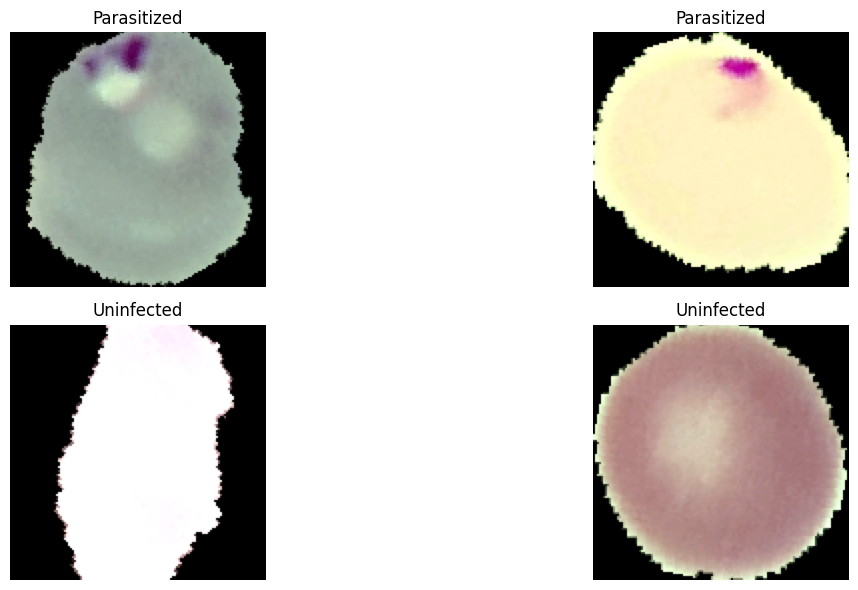

Sample images per class validation dataset:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.3035806].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.007396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.1573474].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.0622959].


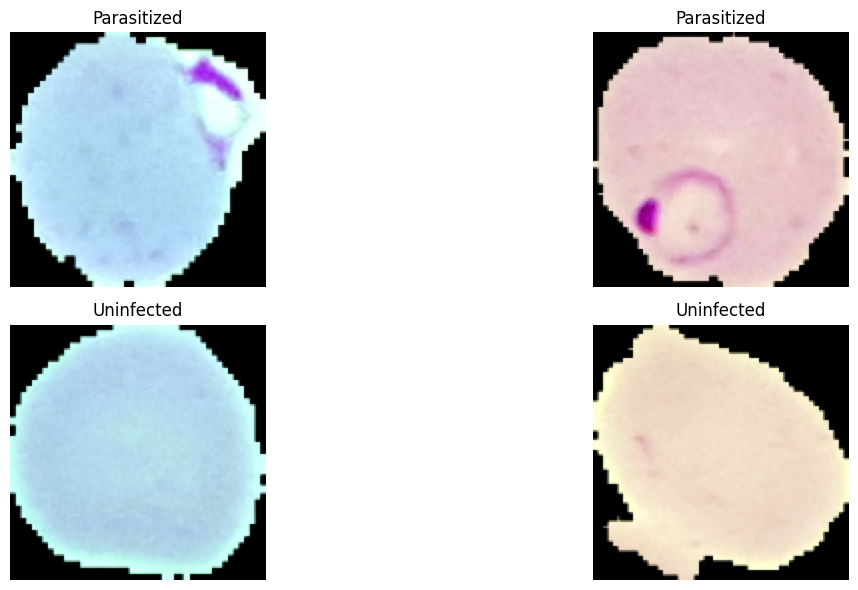

Sample images per class test dataset:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.031002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.0132976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.0132976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30306655..1.230464].


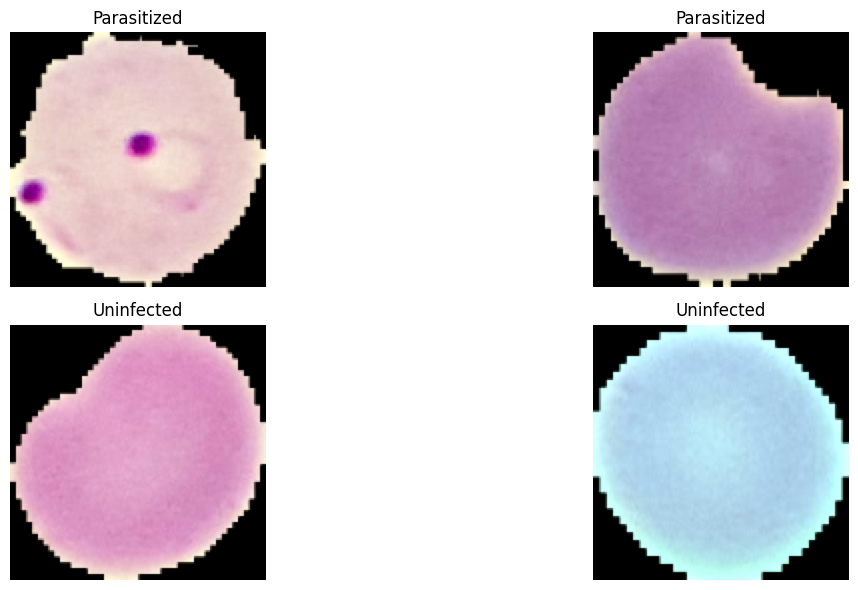

In [3]:
def show_images_per_class(dataset, num_images=2):
    """
    shows `num_images` pictures per class.
    """
    class_indices = defaultdict(list)
    
    # Sammle alle Indizes für jede Klasse
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    num_classes = len(dataset.classes)
    fig, axes = plt.subplots(num_classes, num_images, figsize=(15, num_classes * 3))

    for class_id, indices in class_indices.items():
        selected_indices = np.random.choice(indices, min(num_images, len(indices)), replace=False)
        
        for i, img_idx in enumerate(selected_indices):
            img, label = dataset[img_idx]
            img = img.permute(1, 2, 0).numpy()  # Umwandlung für die Anzeige
            img = (img * 0.5) + 0.5  # Rück-Normalisierung
            
            ax = axes[class_id, i] if num_classes > 1 else axes[i]
            ax.imshow(img)
            ax.set_title(dataset.classes[label])
            ax.axis("off")

    plt.tight_layout()
    plt.show()

print("Sample images per class training dataset:")
show_images_per_class(train_dataset, num_images=2)

print("Sample images per class validation dataset:")
show_images_per_class(val_dataset, num_images=2)

print("Sample images per class test dataset:")
show_images_per_class(test_dataset, num_images=2)
